In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
%load_ext autoreload
%autoreload 2
from config.datasets import dataset_configs
from data.datasets import GenericDataSet, ExperimentalDataSet, TrainingDataSet

BOUND = 16
GenericDataSet.bound = BOUND

In [3]:
import os


def save_model(model):
    model.save_weights(model_path)
#     model.save(model_path, save_format='h5')
    print(model_path)
    print('Saved model!')

def load_model(model, dataset):
    print('Loading model...')
    model_path = os.path.join('/home/miguel/Projects/uni/phd/smlm_z/final_project/smlm_3d/experiments/model_ckpt', dataset)
    model.load_weights(model_path).expect_partial()
    return model
#     return keras.models.load_model(model_path)

import tensorflow as tf
from tensorflow import keras

from keras.layers import RandomTranslation, GaussianNoise, Normalization, BatchNormalization, ReLU
from keras import Model
from keras import layers as Layers
from keras.layers import Dense, Dropout
from keras.layers import MaxPooling2D, GlobalAveragePooling2D, Conv2D

from workflow_v2 import eval_model

SEED = 42
class ResBlock(Model):
    def __init__(self, channels, stride=1):
        super(ResBlock, self).__init__(name='ResBlock')
        self.flag = (stride != 1)
        self.conv1 = Conv2D(channels, 3, stride, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(channels, 3, padding='same')
        self.bn2 = BatchNormalization()
        self.relu = ReLU()
        if self.flag:
            self.bn3 = BatchNormalization()
            self.conv3 = Conv2D(channels, 1, stride)

    def call(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        if self.flag:
            x = self.conv3(x)
            x = self.bn3(x)
        x1 = Layers.add([x, x1])
        x1 = self.relu(x1)
        return x1


class ResNet34(Model):
    prob_space = False
    def __init__(self, enable_dropout=False):
        super(ResNet34, self).__init__(name='ResNet34')
        self.transpose = RandomTranslation(0.1, 0.1)
        self.conv1 = Conv2D(64, 7, 2, padding='same')
        self.bn = BatchNormalization()
        self.relu = ReLU()
        self.mp1 = MaxPooling2D(3, 2)

        self.conv2_1 = ResBlock(64)
        self.conv2_2 = ResBlock(64)
        self.conv2_3 = ResBlock(64)

        self.conv3_1 = ResBlock(128, 2)
        self.conv3_2 = ResBlock(128)
        self.conv3_3 = ResBlock(128)
        self.conv3_4 = ResBlock(128)

        self.conv4_1 = ResBlock(256, 2)
        self.conv4_2 = ResBlock(256)
        self.conv4_3 = ResBlock(256)
        self.conv4_4 = ResBlock(256)
        self.conv4_5 = ResBlock(256)
        self.conv4_6 = ResBlock(256)

        self.conv5_1 = ResBlock(512, 2)
        self.conv5_2 = ResBlock(512)
        self.conv5_3 = ResBlock(512)

        self.pool = GlobalAveragePooling2D()
        self.fc1 = Dense(512)
        self.dp1 = Dropout(0.5)
        self.fc2 = Dense(512)
        self.dp2 = Dropout(0.5)
        self.fc3 = Dense(1)

    def call(self, inp, training, enable_dropout=False):
        x, coords = inp
        
        if training:
            x = self.transpose(x)
        
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.mp1(x)

        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.conv2_3(x)

        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.conv3_4(x)

        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        x = self.conv4_4(x)
        x = self.conv4_5(x)
        x = self.conv4_6(x)

        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.conv5_3(x)

        x = self.pool(x)

        # Concat norm X/Y coordinates
        x = tf.concat((x, coords), axis=1)
        
        x = self.fc1(x)
        x = self.dp1(x, training=enable_dropout)
        x = self.fc2(x)
        
        if self.prob_space:
            return x

        x = self.dp2(x, training=enable_dropout)
        x = self.fc3(x)
        # Restrict to valid output range [-1000, 1000]    
#         x = tf.tanh(x) * 1000
        return x

#     def test_step(self, data):
#         (img, coords), y = data
#         y_pred = self((img, coords), training=False)

#         shifted_pred = shift_correction(y, y_pred)

#         self.compiled_loss(y, shifted_pred, regularization_losses=self.losses)
#         self.compiled_metrics.update_state(y, shifted_pred)
#         # Return a dict mapping metric names to current value.
#         # Note that it will include the loss (tracked in self.metrics).
#         return {m.name: m.result() for m in self.metrics}

    def call_with_dropout(self, inp, enable_dropout, n=5):
        preds = []
        for i in range(n):
            preds.append(self.call(inp, False, True))
        return preds


def load_regression_model():
    # model = Sequential()
    # model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    # model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    # model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    # model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    # model.add(Flatten())
    # model.add(Dense(512, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(1, activation='linear'))

    model = ResNet34()
#     model = res34()
    model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(learning_rate=0.01, decay=1e-6),metrics=['mean_absolute_error'])
    return model

dataset = '20220331_with_and_without_AF_long_ACQ_STORM'
model = load_model(load_regression_model(), dataset)


Loading model...


Reading img...
Loading /home/miguel/Projects/uni/data/smlm_3d/20220425_Miguel/2um_20nm_atto647_1/2um_20nm_atto647_1_MMStack_Default.ome.tif
Loading /home/miguel/Projects/uni/data/smlm_3d/20220425_Miguel/2um_20nm_atto647_1/2um_20nm_atto647_1_MMStack_Default_multi_emitter.csv


/home/miguel/Projects/uni/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


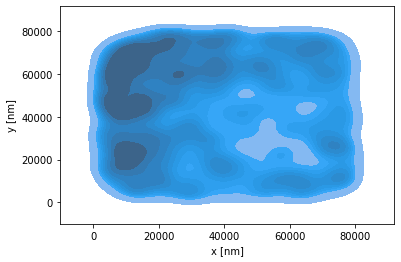

  8%|▊         | 379/4816 [00:00<00:02, 1895.40it/s]

5044 emitters before filtering
4816 emitters after borders


100%|██████████| 4816/4816 [00:02<00:00, 1959.31it/s]


Rows 9 Cols 10 n_spaces 90 n_psfs 90


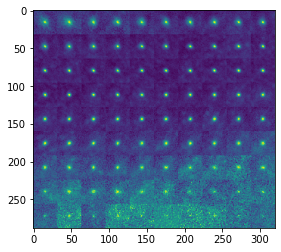

(90, 32, 32)


In [4]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from data.visualise import show_psf_axial
from data.visualise import grid_psfs
import numpy as np

# construct compound PSF
dataset = '20220425_Miguel'
cfg = dataset_configs[dataset]['storm_slide']
# cfg['csv'] = cfg['csv'].replace('_filtered', '')
storm_dataset = ExperimentalDataSet(cfg, normalize_psf=False, lazy=True, transform_data=False)
storm_dataset.bound = 16
storm_dataset.filter_emitters_proximity = False
storm_dataset.csv_data_bak = storm_dataset.csv_data.copy(deep=True)
storm_dataset.csv_data = storm_dataset.csv_data[storm_dataset.csv_data['sigma [nm]'] > 10]

storm_coords = storm_dataset.csv_data[['x [nm]', 'y [nm]']]

import seaborn as sns
sns.kdeplot(storm_dataset.csv_data['x [nm]'], storm_dataset.csv_data['y [nm]'], fill=True)
plt.show()

target = [[20000, 10000]]
dists = cdist(target, storm_coords).squeeze()
d = np.argwhere(dists < 10000).squeeze()
storm_dataset.csv_data = storm_dataset.csv_data.iloc[d]
storm_dataset.prepare_data()

frames = sorted(set(storm_dataset.csv_data['frame']))
psf = []
z_coords = []
for f in frames:
    psf_idx = np.argwhere(storm_dataset.csv_data['frame'].to_numpy() == f)
#     if len(psf_idx) < 5:
#         continue
        
    frame_imgs = storm_dataset.data[0][psf_idx].squeeze()
    if frame_imgs.ndim > 2:
        frame_imgs = np.mean(frame_imgs, axis=0)
#     plt.imshow(frame_imgs)
#     plt.title(str(f))
#     plt.show()
    
    
    psf.append(frame_imgs)
    z_coords.append(f * storm_dataset.voxel_sizes[0])

psf = np.stack(psf)
psf = storm_dataset.normalise_image(psf)
plt.imshow(grid_psfs(psf))
plt.show()
print(psf.shape)


Loading model...
(90, 32, 32, 1) (90, 2)


/home/miguel/Projects/uni/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


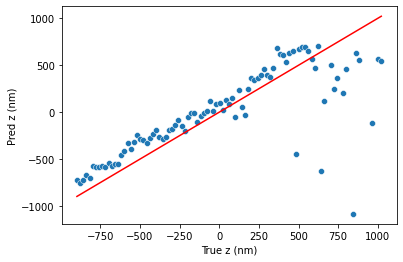

In [10]:
model_dataset = '20220425_Miguel__20nm'
model = load_model(load_regression_model(), model_dataset)

psf = psf.squeeze()[:, :, :, np.newaxis]
coords = np.repeat(storm_dataset.convert_xy_coords_to_polar(np.array(target)), psf.shape[0], axis=0)
print(psf.shape, coords.shape)
pred_y = model.predict((psf, coords)).squeeze()
z_coords = z_coords.astype(float)
z_coords -= np.asarray(z_coords).mean()
pred_y -= np.asarray(pred_y).mean()
sns.scatterplot(z_coords, pred_y)
sns.lineplot(x=z_coords, y=z_coords, color='r')
plt.xlabel('True z (nm)')
plt.ylabel('Pred z (nm)')

plt.show()
        